# "Relationship between reflectivity and elastic impedance", reproducing figure 5.62 from Simm & Bacon (2014)

While I was looking for alternative ways to compute synthetic pre-stack data, I almost inadvertently stumbled into the equations for Elastic Impedance, which have always been sort of under my radar so far.

In my new job as explorationist, I am rediscovering the joy of doing simple things ("with lots of data", as Pat Connolly likes to say); without the possibility to do fancy rock physics or inversions, I am enjoying the challenge to solve geo-riddles with just wireline logs and seismic data. At the same time, I also find invigorating the relative freedom to find solutions to geological and geophysical puzzles using very basic concepts and techniques, the sort of things that you can do with any interpretation software - and Python code!.

The usual way I build synthetic pre-stack gathers is through AVO equations to calculate the reflectivity at various angles of incidence using any AVO equation like Aki-Richards or Shuey (or the others you can find in [bruges](http://www.agilegeoscience.com/blog/2015/8/5/introducing-bruges)). The input is two copies of the same elastic logs ($V_p$, $V_s$, $\rho$) shifted by one sample (to get the "upper" and "lower" halfspaces that the AVO equations require). Then the reflectivities are convolved with the geophysicist's best friend, the Ricker wavelet to get angle-dependent seismic traces.

Connolly introduced the concept of elastic impedance ($EI$) in 1999 as an elegant solution to tie the interpretation of far angle stacks to well data (near-offsets can be tied to well data through simple acoustic impedance). And what he did was basically to rearrange the Aki-Richards equations so that the output is not reflectivity but something like a proper log, which is strikingly similar in shape to acoustic impedance ($AI$), until something interesting happens (like a hydrocarbon-bearing sand) and then elastic impedance shows a different response from $AI$.

The formula looks like this:

$$ EI = V_p^a V_s^b \rho^c $$

where:

$$ a = 1 + \tan^2 \theta $$
$$ b = -8 k \sin^2 \theta $$
$$ c = 1 - 4 k \sin^2 \theta $$
$$ k = ( V_s / V_p )^2 $$

Connolly also presents an alternative form which "can be used for generating synthetics" (his own words, check the Appendix in Connolly, 1999):
    
$$ EI = V_p \rho^* $$
$$ \rho^\ast = V_p^{(\tan^2 \theta)} V_s^b \rho^c ) $$

In practice we have $EI$ expressed as the product of velocity and a pseudo-density ($ \rho^* $) that is angle-dependant. So any kind of 1D modeling can be used to generate angle-dependant synthetic seismograms, and the usual calibration of $ V_p $ through time-depth tables ensures the correct positioning in time. 

Finally, another equation which I need later to reproduce the figure, is the normalized function by Whitcombe (2002):

$$ EI^{NORM} = \rho_0 V_{p0} \, \left[ (V_p/V_{p0})^a  (V_s/V_{s0})^b (\rho/\rho_0)^c \right]$$

Where $V_{p0}$, $V_{s0}$, $\rho_0$ are averages of the input elastic logs.
    
Is it easier to use the AVO equations, get the angle-dependent reflectivities and convolve those with a wavelet, or build a series of $EI$ logs and from those derive the reflectivities like if it is a zero-offset seismogram? I don't see any difference between the two, in terms of results (obviously they are equivalent as they are just rearrangements of the same equations) or convenience.

### and the figure?

Right, the figure -- sorry, I was carried away by the elegance and simplicity of the elastic impedance concept.

The thing is that I was reading my copy of "Seismic Amplitude" by Simm & Bacon and I wanted to reproduce this figure, if only to check if my elastic impedance code was correct. 

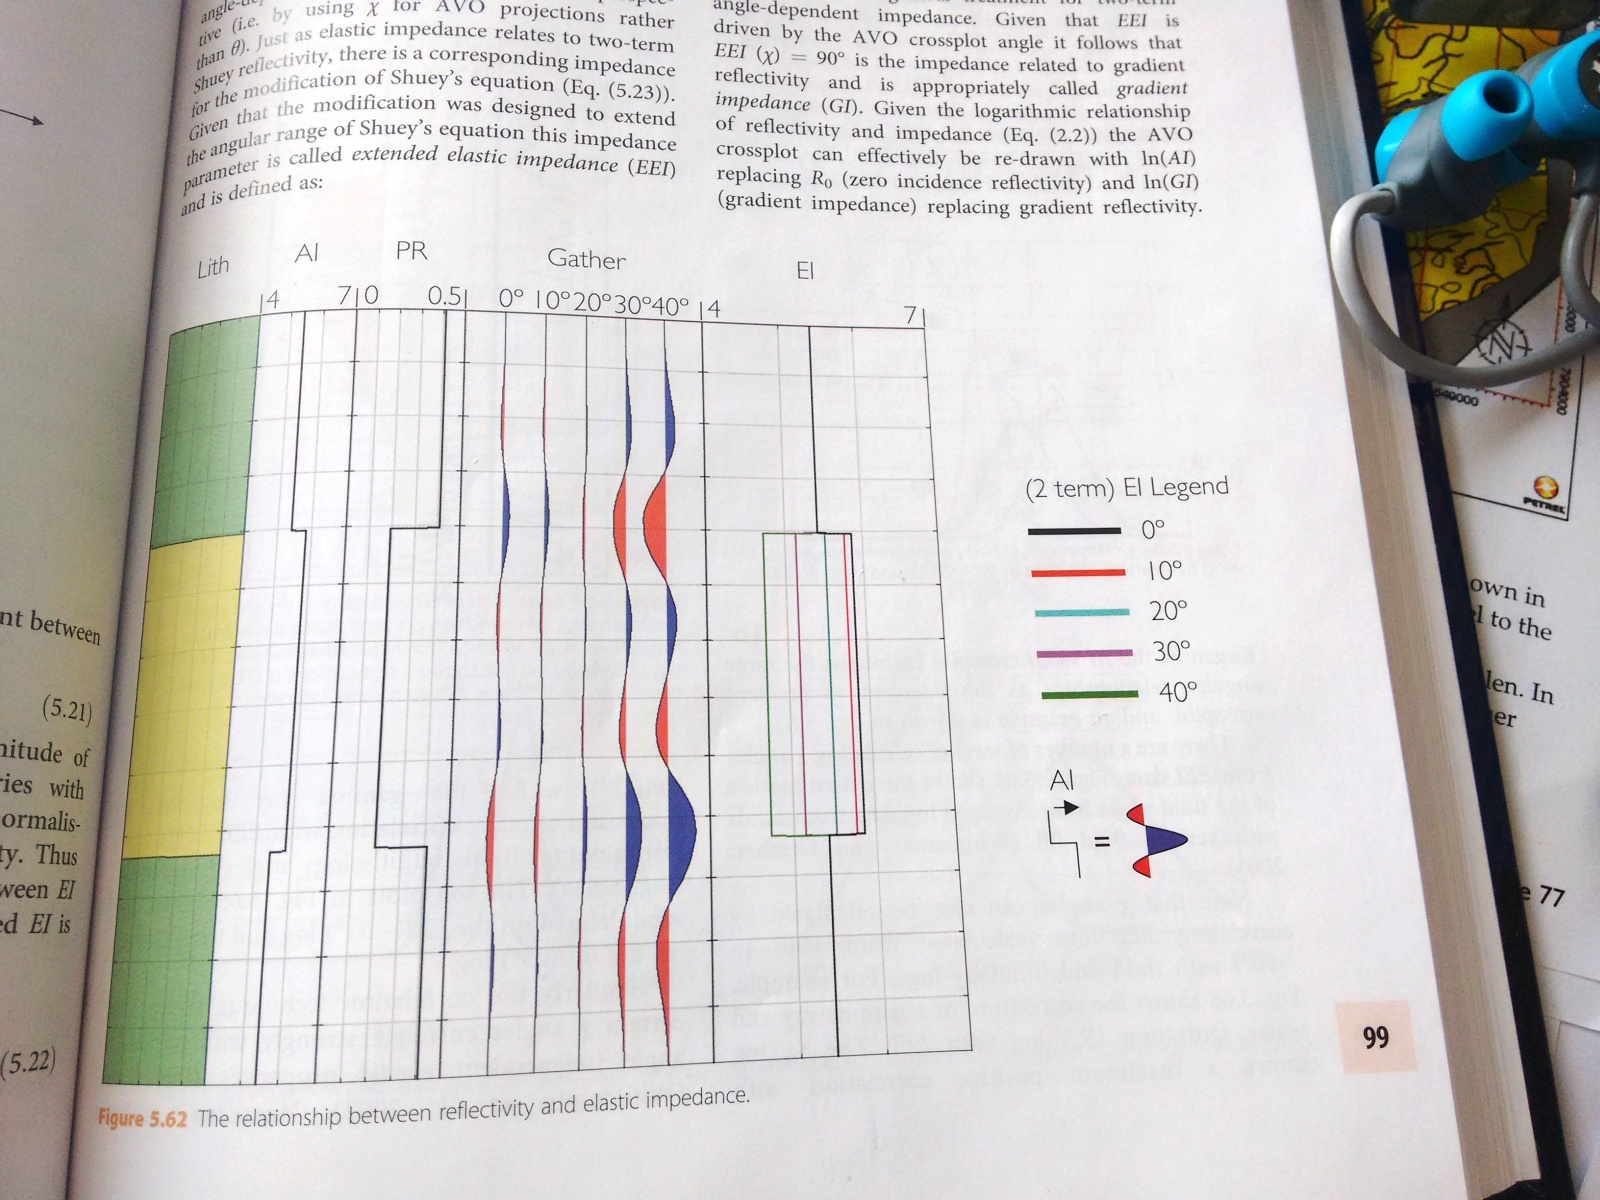

In [1]:
from IPython.display import Image
Image(filename='Simm_2014_fig5-62.jpg', width=800)

## code to make that figure

Let's load the usual libraries:

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import bruges as b

%matplotlib inline
# comment out the following if you're not on a Mac with HiDPI display
%config InlineBackend.figure_format = 'retina'

The first problem was to get $V_p$, $V_s$, $\rho$ from the values of acoustic impedance ($AI$) and poisson's ratio ($PR$) that you can sort of read in the second and third column from right.


$$ AI = \rho V_p  $$

$$ PR = \frac{ V_p^2 - 2 V_s^2} { 2 (V_p^2 - V_s^2) } $$

So I have three unknowns and only two equations -- let's call Gardner's relation to the rescue (the parameters are the standard for a mixture of sand/shale lithology with velocities in m/s and density in g/cc):

$$ \rho = 0.31 V_p^{0.25} $$

therefore

$$ V_p = (\rho / 0.31)^{1/0.25} $$

combining the two equations for $V_p$ and $AI$ I have a simple way to get the density:

$$ \rho = (0.31^{1/0.25} AI )^{1/5} $$

from that, I can calculate $V_p$:

$$ V_p = \frac{AI}{\rho} $$

And $V_s$:

$$ VpVs= \sqrt{ \frac{1-PR}{0.5-PR}} $$

$$ V_s = \frac{V_p}{VpVs} $$

Apologies for all the people who are fluent in basic maths, I have to admit that I had to spend an embarassing amount of time to get to this point.

Anyway, let's code all of this in a function and apply it to the values of $AI$ and $PR$:

In [3]:
def get_elprop(ip,pr):
    vpvs= np.sqrt( (1-pr)/ (0.5-pr) )
    rho = (ip * 0.31**4)**(1/5)
    vp = ip / rho
    vs = vp / vpvs
    return vp,vs,rho

ip1=5500
pr1=0.4
vp1, vs1, rho1 = get_elprop(ip1,pr1)
print('First rock (green): given Ip={:.0f} and PR={:.2f} --> vp={:.0f}, vs={:.0f}, rho={:.2f}'.format(ip1,pr1,vp1,vs1,rho1))

ip2=5900
pr2=0.2
vp2, vs2, rho2 = get_elprop(ip2,pr2)
print('Second rock (yellow): given Ip={:.0f} and PR={:.2f} --> vp={:.0f}, vs={:.0f}, rho={:.2f}'.format(ip2,pr2,vp2,vs2,rho2))

First rock (green): given Ip=5500 and PR=0.40 --> vp=2507, vs=1024, rho=2.19
Second rock (yellow): given Ip=5900 and PR=0.20 --> vp=2652, vs=1624, rho=2.22


This is the code the elastic impedance; first the alternate form described above, then the normalized equation (Whitcombe 2002):

In [4]:
def elastic_impedance(vp, vs, rho, alpha, k=0.25):
    alpha = np.radians(alpha)
    q = np.tan(alpha)**2
    w = -8*k * (np.sin(alpha)**2)
    e = 1 - 4*k * (np.sin(alpha)**2)
    rho_star = vp**q *  vs**w * rho**e
    ei = vp * rho_star
    return ei

def elastic_impedance_norm(vp, vs, rho, alpha, scal, k=0.25):
    alpha = np.radians(alpha)
    vp0, vs0, rho0 = scal[0], scal[1], scal[2]
    a = 1 + (np.tan(alpha)) ** 2
    b = -8 * k * ((np.sin(alpha)) ** 2)
    c = 1 - 4 * k * ((np.sin(alpha)) ** 2)
    ei = vp0*rho0 * ( (vp/vp0) ** a * (vs/vs0) ** b * (rho/rho0) ** c)
    return ei

I will compute the $EI$ logs in both their normal and normalized versions, and will use the latter to reproduce the figure. Note that in this case I am using the scaling factors as being equal to the elastic properties of the first layer (a common approach is to take them as being the average computed over the entire log or a selected range of interest):

In [5]:
n_samples = 400
interface1 = int(0.4*n_samples)
interface2 = int(0.6*n_samples)

model=np.zeros((n_samples,3))
model[:interface1,:]=[vp1,vs1,rho1]
model[interface2:,:]=[vp1,vs1,rho1]
model[interface1:interface2,:]=[vp2,vs2,rho2]

z=np.arange(n_samples)
ip=model[:,0]*model[:,2]
pr=(model[:,0]**2-2*model[:,1]**2) / (2*(model[:,0]**2-model[:,1]**2))

scal = vp1, vs1, rho1

ang=np.arange(0,50,10)

wavelet = b.filters.ricker(0.25, 0.001, 20)

ei  = np.zeros((n_samples,ang.size))
ei_norm  = np.zeros((n_samples,ang.size))
synt  = np.zeros((n_samples,ang.size))
for i,alpha in enumerate(ang):
    ei[:,i] = elastic_impedance(model[:,0], model[:,1], model[:,2], alpha)
    ei_norm[:,i] = elastic_impedance_norm(model[:,0], model[:,1], model[:,2], alpha, scal)
    RC = (ei[1:,i] - ei[:-1,i]) / (ei[1:,i] + ei[:-1,i])
    RC = np.append(np.nan, RC)
    RC = np.nan_to_num(RC)
    synt[:,i] = np.convolve(RC, wavelet, mode='same')

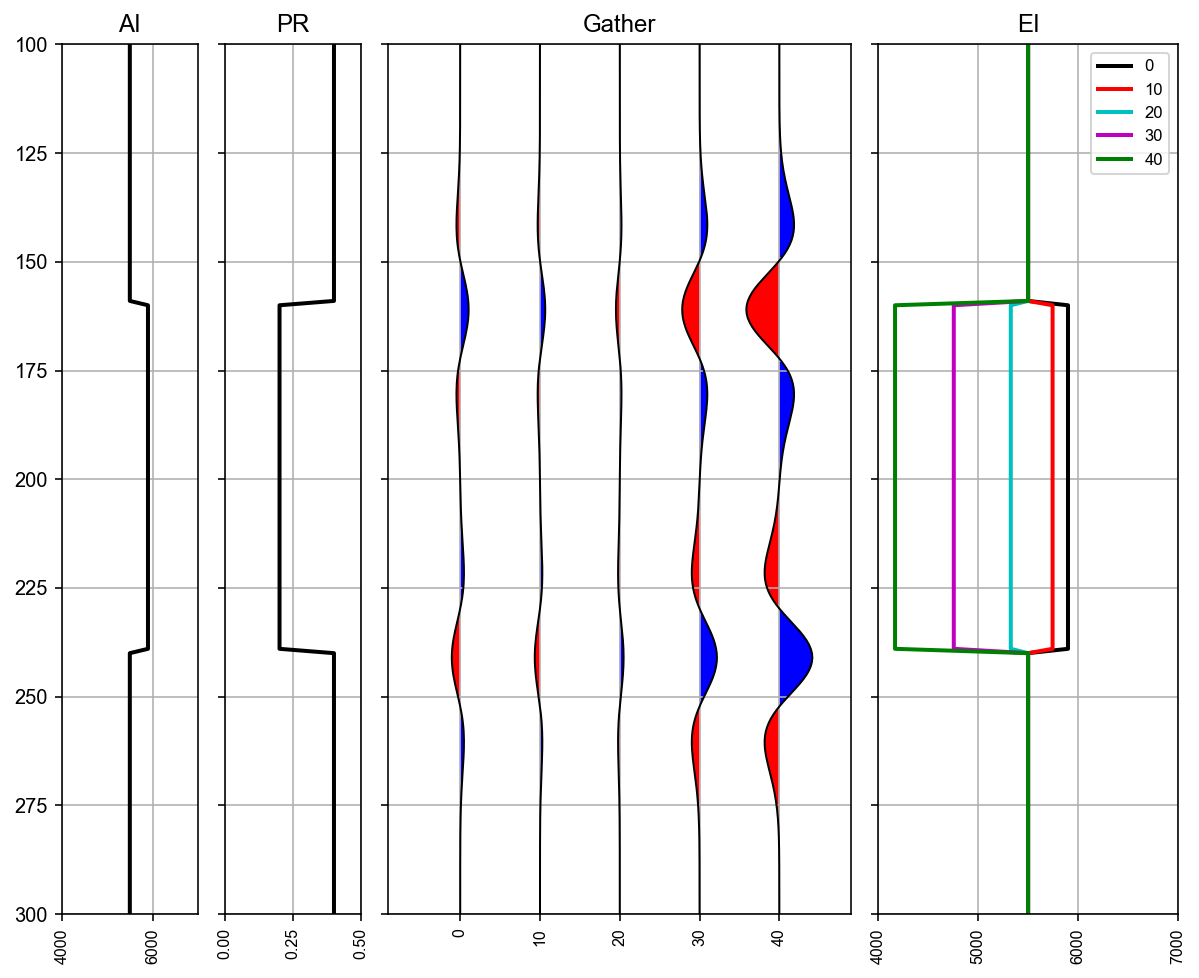

In [6]:
f=plt.subplots(figsize=(10, 8))
ax0 = plt.subplot2grid((1,7), (0,0), colspan=1)
ax1 = plt.subplot2grid((1,7), (0,1), colspan=1)
ax2 = plt.subplot2grid((1,7), (0,2), colspan=3)
ax3 = plt.subplot2grid((1,7), (0,5), colspan=2)

# track 1: AI
ax0.plot(ip, z, '-k', linewidth=2)
ax0.set_xlim(4000,7000)

# track 2: PR
ax1.plot(pr, z, '-k', linewidth=2)
ax1.set_xlim(0,0.5)
ax1.set_yticklabels([])

# track 3: seismogram
for i in range(ang.size):
    trace=synt[:,i]*3
    ax2.plot(trace+i,z,color='k', linewidth=1)
    ax2.fill_betweenx(z,trace+i,i, where=trace+i>i, facecolor='b', linewidth=0)
    ax2.fill_betweenx(z,trace+i,i, where=trace+i<i, facecolor='r', linewidth=0)
ax2.set_xlim(-0.9,synt.shape[1]-.1)
ax2.set_yticklabels([])
ax2.set_xticks((0, 1, 2, 3, 4))
ax2.set_xticklabels((0, 10, 20, 30, 40))
    
# track 4: EI logs
colr=['k','r','c','m','g']
for i in range(ang.size):
    ax3.plot(ei_norm[:,i], z, linewidth=2, label=ang[i], color=colr[i])
ax3.set_xlim(4000,7000)
ax3.set_yticklabels([])
ax3.legend(fontsize='small')

ax0.set_title('AI')
ax1.set_title('PR')
ax2.set_title('Gather')
ax3.set_title('EI')

for aa in [ax0, ax1, ax2, ax3]:
    aa.set_ylim(100,300)
    aa.invert_yaxis()
    aa.grid()
    plt.setp(aa.xaxis.get_majorticklabels(), rotation=90, fontsize=8)

Yes I know. The EI logs on the last track are not quite the same as in the original figure, i.e. the 40 degrees reach very low values unlike the original figure.

### addendum

Just for fun, this is a comparison between the output of the two equations:

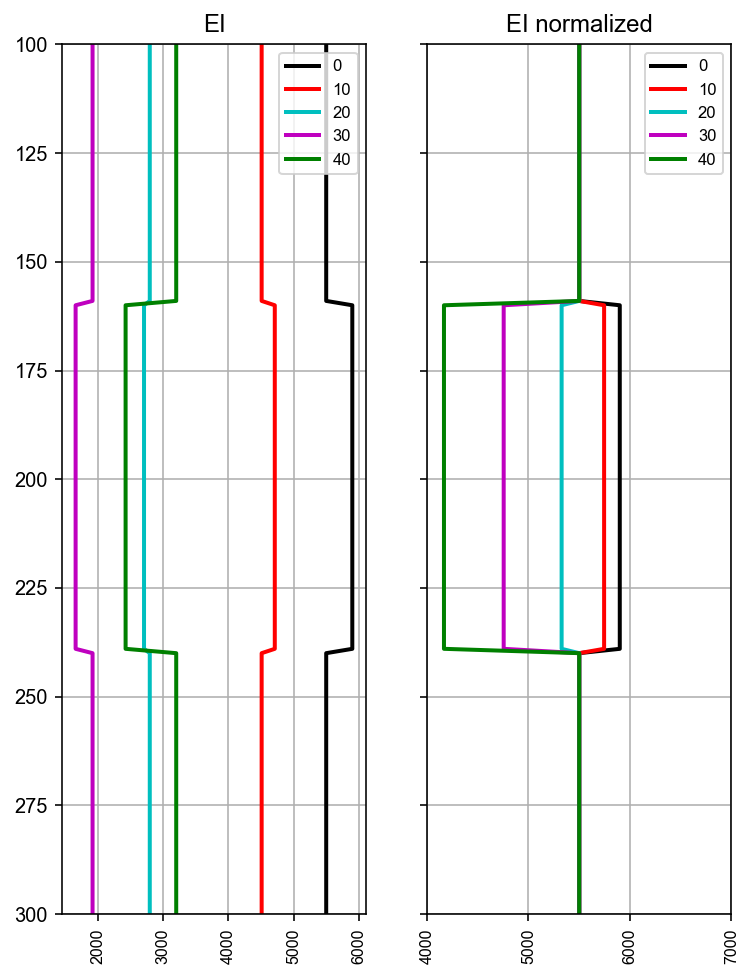

In [10]:
f,ax=plt.subplots(nrows=1, ncols=2, figsize=(6, 8))
for i in range(ang.size):
    ax[0].plot(ei[:,i], z, linewidth=2, label=ang[i], color=colr[i])
    ax[1].plot(ei_norm[:,i], z, linewidth=2, label=ang[i], color=colr[i])

ax[0].set_title('EI')
ax[1].set_title('EI normalized')
ax[1].set_yticklabels([])
ax[1].set_xlim(4000,7000)

for aa in ax:
    aa.set_ylim(100,300)
    aa.invert_yaxis()
    aa.grid()
    plt.setp(aa.xaxis.get_majorticklabels(), rotation=90, fontsize=8)
    aa.legend(fontsize='small', loc='upper right')

I think I'm happy with that however. The important part if that the synthetic traces are the same as in the book. As I wrote [elsewhere](http://nbviewer.ipython.org/github/aadm/geophysical_notes/blob/master/top_heimdal_map.ipynb), I do have a life after all.

## references

* Connolly, Elastic impedance, The Leading Edge, 1999.
* Whitcombe, Elastic impedance normalization, Geophysics, 2002.
* Simm & Bacon, Seismic Amplitude: An Interpreter's Handbook, Cambridge University Press, 2014.